### RFM With KMeans clustering

---

In [1]:
import pandas as pd 
import datetime as dt

In [17]:
df = pd.read_csv('customers.csv')
df.head()

,CustomerID,InvoiceDate,InvoiceNo,TotalPrice
0,1,2023-07-01 10:00:00,1001,150.0
1,1,2023-07-15 14:30:00,1002,200.0
2,2,2023-06-20 09:00:00,1003,300.0
3,2,2023-07-05 16:00:00,1004,250.0
4,3,2023-07-10 11:00:00,1005,100.0


In [22]:
#creating a reference date to calculate the recency
today_date = dt.datetime(2023 , 8 , 1)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [23]:
#calculating the recency , frequency & monetary value
df_clustering = df.groupby('CustomerID').agg({
    'InvoiceDate' : lambda InvoiceDate : (today_date - InvoiceDate.max()).days,
    'InvoiceNo' : 'nunique',
    'TotalPrice' : 'sum'
})

df_clustering.columns = ['recency' , 'frequency' , 'monetary']
df_clustering

,recency,frequency,monetary
CustomerID,,,
1,13,7,1000.0
2,21,7,1550.0
3,7,5,800.0
4,14,5,1250.0
5,17,5,1300.0
6,12,5,550.0
7,13,5,950.0
8,6,5,950.0
9,12,5,1250.0


In [34]:
#standardization of the data 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)
df_scaled = pd.DataFrame(data = df_scaled , columns=['recency' , 'frequency' , 'monetary'])
df_scaled['CustomerID'] = df_clustering.index
df_scaled = df_scaled.set_index('CustomerID' , drop = True)
df_scaled

,recency,frequency,monetary
CustomerID,,,
1,-0.023776,2.0,-0.323498
2,1.878292,2.0,1.653436
3,-1.450327,-0.5,-1.042383
4,0.213983,-0.5,0.575108
5,0.927258,-0.5,0.754829
6,-0.261534,-0.5,-1.940990
7,-0.023776,-0.5,-0.503220
8,-1.688085,-0.5,-0.503220
9,-0.261534,-0.5,0.575108


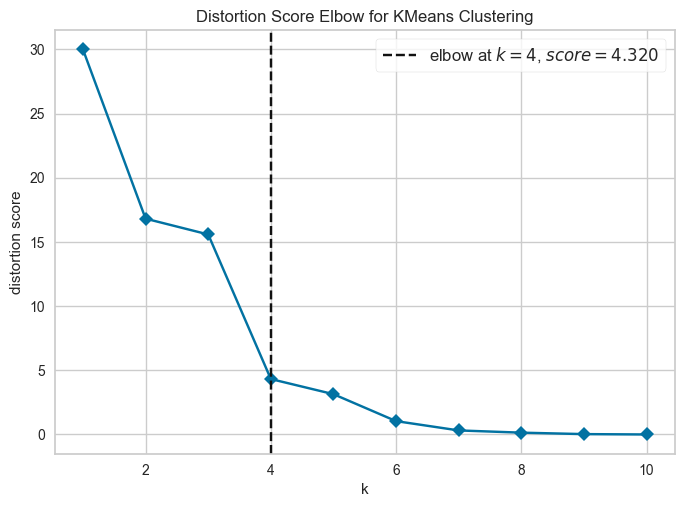

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
#lets determine the optimal number of k using elbow method 
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()
visualizer = KElbowVisualizer(model , k = (1,11) , timings= False , random_state = 42)
visualizer.fit(df_scaled)
visualizer.show()

In [41]:
kmeans = KMeans(n_clusters=4 , n_init=15 , random_state= 42)
kmeans.fit(df_scaled)

centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(data = centroids , columns= list(df_scaled))
centroids_df

,recency,frequency,monetary
0,0.309086,-0.5,0.431331
1,-1.133316,-0.5,-1.162198
2,-0.023776,2.0,-0.323498
3,1.878292,2.0,1.653436


In [45]:
df_labels = pd.DataFrame(kmeans.labels_ , columns=['labels'])
df_labels['labels'] = df_labels['labels'].astype('category')

df_kmeans = df_clustering.copy()
df_kmeans['labels'] = df_labels['labels'].values
df_kmeans

,recency,frequency,monetary,labels
CustomerID,,,,
1,13,7,1000.0,2
2,21,7,1550.0,3
3,7,5,800.0,1
4,14,5,1250.0,0
5,17,5,1300.0,0
6,12,5,550.0,1
7,13,5,950.0,0
8,6,5,950.0,1
9,12,5,1250.0,0


In [47]:
agg_list = ['mean' , 'count' , 'max']
df_kmeans[['labels' , 'recency' , 'frequency' , 'monetary']].groupby('labels').agg(agg_list)

recency           frequency               monetary              
             mean count max      mean count max         mean count     max
labels                                                                    
0       14.400000     5  17       5.0     5   5  1210.000000     5  1300.0
1        8.333333     3  12       5.0     3   5   766.666667     3   950.0
2       13.000000     1  13       7.0     1   7  1000.000000     1  1000.0
3       21.000000     1  21       7.0     1   7  1550.000000     1  1550.0

# RFM Clusters Analysis

## Cluster 0
- **Recency**: 
  - Mean: 14.4 days
  - Count: 5
  - Max: 17 days
- **Frequency**: 
  - Mean: 5.0 purchases
  - Count: 5
  - Max: 5 purchases
- **Monetary**: 
  - Mean: \$1210.00
  - Count: 5
  - Max: \$1300.00
- **Insight**: These customers purchase moderately frequently and spend a significant amount. They are valuable and should be engaged with loyalty programs and personalized offers.

## Cluster 1
- **Recency**: 
  - Mean: 8.33 days
  - Count: 3
  - Max: 12 days
- **Frequency**: 
  - Mean: 5.0 purchases
  - Count: 3
  - Max: 5 purchases
- **Monetary**: 
  - Mean: \$766.67
  - Count: 3
  - Max: \$950.00
- **Insight**: These customers purchase frequently and spend a moderate amount. They are loyal customers who can be encouraged to spend more through targeted promotions.

## Cluster 2
- **Recency**: 
  - Mean: 13.0 days
  - Count: 1
  - Max: 13 days
- **Frequency**: 
  - Mean: 7.0 purchases
  - Count: 1
  - Max: 7 purchases
- **Monetary**: 
  - Mean: \$1000.00
  - Count: 1
  - Max: \$1000.00
- **Insight**: This is a single customer who purchases frequently and spends a significant amount. They are highly valuable and should be given special attention to maintain their loyalty.

## Cluster 3
- **Recency**: 
  - Mean: 21.0 days
  - Count: 1
  - Max: 21 days
- **Frequency**: 
  - Mean: 7.0 purchases
  - Count: 1
  - Max: 7 purchases
- **Monetary**: 
  - Mean: \$1550.00
  - Count: 1
  - Max: \$1550.00
- **Insight**: This is another single customer who purchases frequently and spends the most. They are extremely valuable and should be treated as a VIP with exclusive offers and exceptional service.
